Поскольку у pymc3 какие-то проблемы с theano, на Colab пришлось поставить dev версию через github.

In [40]:
#!pip install git+https://github.com/pymc-devs/pymc3 numpyro numpy pandas matplotlib seaborn arviz scipy

Поскольку LaTex не стоит на колабовской машине, а нам хотелось бы его использовать и в графиках, поставим:

In [2]:
#! sudo apt-get install texlive-latex-recommended 
#! sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended  
#! wget http://mirrors.ctan.org/macros/latex/contrib/type1cm.zip 
#! unzip type1cm.zip -d /tmp/type1cm 
#! cd /tmp/type1cm/type1cm/ && sudo latex type1cm.ins
#! sudo mkdir /usr/share/texmf/tex/latex/type1cm 
#! sudo cp /tmp/type1cm/type1cm/type1cm.sty /usr/share/texmf/tex/latex/type1cm 
#! sudo texhash 
#!apt install cm-super

In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import arviz as az
sns.set()
from scipy import stats

You are running the v4 development version of PyMC3 which currently still lacks key features. You probably want to use the stable v3 instead which you can either install via conda or find on the v3 GitHub branch: https://github.com/pymc-devs/pymc3/tree/v3


In [5]:
import jax.numpy as jnp
import jax
from jax import random, vmap
from jax.scipy.special import logsumexp

In [6]:
import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS

Вспомним формулу Байеса:
$$
p(\theta | x) = \dfrac{p(x | \theta)p(\theta)}{p(x)}
$$

Простой дискретный пример.

В Небольшом пруду водятся караси и щуки, причём согласно поверью, в любой момент времени доля карасей в Небольшом пруду может равновероятно быть либо $1/3$, либо $2/3$ в зависимости от погодных условий. Исследовательница Авдотья вылавливает десять рыб подряд. Оказалось, что в полученной выборке шесть щук и четыре карася.

а) Найдите оценку максимального правдоподобия $\hat{p}_{c}$, рассуждая с позиций частотного подхода.

Ответ: $\hat{p}_{c} = 4/10$

б) Сделаем то же самое в рамках байесовского подхода. 

$$ 
p(\theta | y)  \propto p(y| \theta) \times p(\theta)
$$

$ p(\theta) = 1/2 $ (оба значения доли карасей равновероятны), $ p(y| \theta) = p^x \times (1-p)^{n-x}$. Посчитаем апостериорное распределение для обоих возможных значений $p$: 

In [7]:
p1 = (1/3) ** 4 * (2/3) ** 6 * (1/2)
p2 = (2/3) ** 4 * (1/3) ** 6 * (1/2)
print(f"Апостериорная вероятность того, что вероятность поймать карася 1/3, составляет {p1/(p1+p2)}.")
print(f"Апостериорная вероятность того, что вероятность поймать карася 2/3, составляет {p2/(p1+p2)}.")

Апостериорная вероятность того, что вероятность поймать карася 1/3, составляет 0.8.
Апостериорная вероятность того, что вероятность поймать карася 2/3, составляет 0.2.


Это вполне логично - 0.4 ближе к 1/3, чем к 2/3. 

#### Задание 1. Караси и щуки.

В Большом пруду водятся караси и щуки, причём согласно поверью, вероятность встретить карася равномерно распределена на отрезке от 0 до 1. Ловля рыбы в Большом пруду запрещена, поэтому исследовательница Авдотья решает провести численный эксперимент для вывода апостериорного распределения вероятности встретить карася.

Сгенерируйте выборку из из 100 наблюдений, каждое из которых является идентификатором того, является ли пойманная рыба карасём.

In [8]:
y = stats.bernoulli(p=0.3).rvs(100)
print('Доля карасей в выборке:', y.mean())
y

Доля карасей в выборке: 0.3


array([0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0])

1. Задайте вероятностную модель.

In [9]:
def model(y):
  p = numpyro.sample('share', dist.Uniform(0, 1))
  y_obs = numpyro.sample('obs', dist.Bernoulli(p), obs=y)

2. Оцените модель и получите приблизительное апостериорное распределение параметров.

In [10]:
kernel = NUTS(model) # NUTS sampler 
# 100 первых наблюдений будет выкинуто при оценке апостериорного распределения
# оставшиеся 500 наблюдений будут сохранены
mcmc = numpyro.infer.MCMC(kernel, num_warmup=100, num_samples=1000)
mcmc.run(random.PRNGKey(123), y = y)
mcmc.print_summary()
samples_1 = mcmc.get_samples()

sample: 100%|██████████| 1100/1100 [00:02<00:00, 428.07it/s, 3 steps of size 9.47e-01. acc. prob=0.87]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     share      0.30      0.05      0.30      0.22      0.38    326.66      1.00

Number of divergences: 0


In [11]:
print(f"Выборочное среднее апостериорного распределения: {samples_1['share'].mean()}.")

Выборочное среднее апостериорного распределения: 0.30321863293647766.


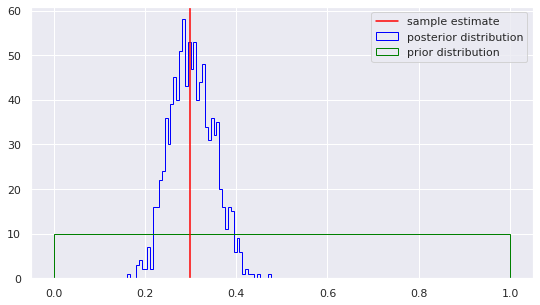

In [12]:
plt.figure(figsize=(9, 5));
plt.hist(samples_1['share'], bins=50, histtype='step', label='posterior distribution', color='blue');
plt.hist(np.linspace(0, 1, 500), bins=50, histtype='step', label='prior distribution', color='green');
plt.axvline(np.mean(y), color='red', label='sample estimate');
plt.legend(loc='best');


У `numpyro` заметно сразу два минуса:
* Нельзя нарисовать динамику по цепям для генерируемого апостериорного распределения.
* Не считаются никакие статистики, которые говорили бы о сходимости апостериорного распределения. В этом плане `PyMC3` гораздо лучше.

Попробуем то же самое сделать через PyMC3, благо синтаксис похож.

In [13]:
ndraws = 1000
nburn = 100

with pm.Model() as model:
  p = pm.Uniform('p', lower=0, upper=1)
  y_obs = pm.Bernoulli('obs', p=p, observed=y)

  step = pm.NUTS()
  trace = pm.sample(# сколько наблюдений мы хотим сэмплировать
                    ndraws,
                    # сколько наблюдений мы хотим "сжечь"
                    tune=nburn, 
                    # удаляем ли мы "сжигаемые" набл-я из апостериорной выборки
                    discard_tuned_samples=True, 
                    # сэмплировщик
                    step=step, 
                    random_seed=np.random.seed(123),
                    # количество ядер, чтоб считать параллельно
                    cores=4,
                    # количество цепей Маркова
                    chains=4)

Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]
INFO:pymc3:NUTS: [p]


Sampling 4 chains for 100 tune and 1_000 draw iterations (400 + 4_000 draws total) took 4 seconds.
INFO:pymc3:Sampling 4 chains for 100 tune and 1_000 draw iterations (400 + 4_000 draws total) took 4 seconds.
The acceptance probability does not match the target. It is 0.9450463689656389, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9330222294348135, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9434963511682429, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9329231600496621, but should be close to 0.8. Try to increase the number of tuning steps.


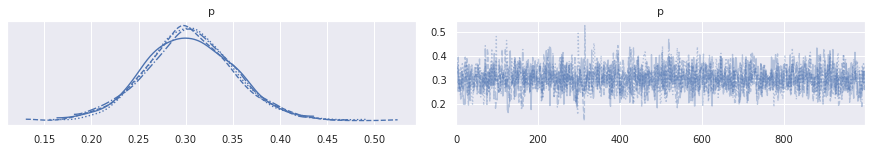

In [14]:
az.plot_trace(trace);

В `trace` есть много чего, при желании можно вытащить, например, выборку из апостериорного распределения для каждой цепи. 

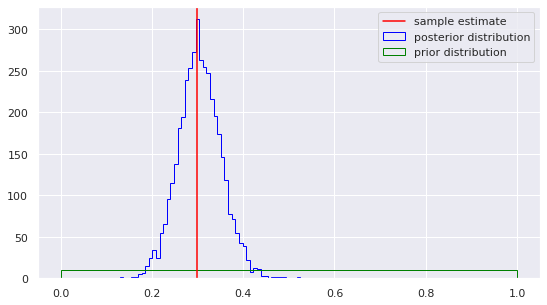

In [15]:
plt.figure(figsize=(9, 5));
plt.hist(np.array(trace.posterior.p).ravel(), bins=50, histtype='step', label='posterior distribution', color='blue');
plt.hist(np.linspace(0, 1, 500), bins=50, histtype='step', label='prior distribution', color='green');
plt.axvline(np.mean(y), color='red', label='sample estimate');
plt.legend(loc='best');

Попробуем вытащить характеристики апостериорного распределения:

In [16]:
az.summary(trace)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
p  0.304  0.047   0.219    0.396      0.001    0.001    1416.0    1670.0    1.0

In [17]:
print(f"Выборочное среднее апостериорного распределения: {np.array(trace.posterior.p).ravel().mean()}.")

Выборочное среднее апостериорного распределения: 0.30441946994335.


Посмотрим, удалились ли те наблюдения из апостериорного распределения, которые мы хотели сжечь. Если да, то shape у trace.posterior.p = (4, 1000).

In [18]:
np.array(trace.posterior.p).shape

(4, 1000)

#### Задание 2. Структурный сдвиг.

In [41]:
years = np.arange(1800, 2000)
casual_1 = stats.poisson(3).rvs(100)
casual_2 = stats.poisson(1).rvs(100)
casualties = np.hstack((casual_1, casual_2))

In [42]:
df = pd.DataFrame({'year': years, 'casualties': casualties})

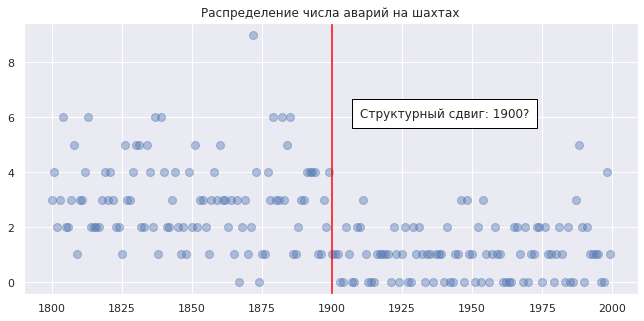

In [43]:
plt.figure(figsize=(11, 5));
plt.plot(df.year, df.casualties, 'o', alpha=0.4, markersize=8);
plt.title('Распределение числа аварий на шахтах');
plt.axvline(1900, color='red');
plt.text(1910, 6, 'Структурный сдвиг: 1900?', bbox={'facecolor': 'white', 'pad': 8, 'edgecolor':'black'});

Будем считать, что авариина шахте распределены по Пуассону и независимы:
$x_i \sim \mathrm{Pois}(\lambda)$, где

$$
\lambda = \begin{cases}
\lambda_1, t < \tau, \\
\lambda_2, t \ge \tau
\end{cases}
$$

Априорное распределение $\lambda$: $\lambda \sim \mathrm{Exp}(\alpha)$, где $alpha$ - некоторый гиперпараметр, который мы не знаем.

Оценим $\alpha$ на основе выборки:

In [44]:
y = casualties
alpha = 1 / np.mean(y)
alpha

0.4938271604938272

In [45]:
with pm.Model() as DisasterModel:
  # априорные распределения параметров
  tau = pm.DiscreteUniform("tau", lower=years.min(), upper=years.max())

  early_rate = pm.Exponential("early_rate", alpha)
  late_rate = pm.Exponential("late_rate", alpha)

  # разные значения alpha в зависимости от tau
  rate = pm.math.switch(tau>=years, early_rate, late_rate)

  # связь y c rate
  y_obs = pm.Poisson('disasters', rate, observed=y)

In [46]:
n_draws = 1000
n_burn = 100

with DisasterModel:
  sample = pm.sample(draws=n_draws,
                     tune=n_burn,
                     chains=4, 
                     cores=4, 
                     random_seed=np.random.seed(123))

Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
INFO:pymc3:CompoundStep
>Metropolis: [tau]
INFO:pymc3:>Metropolis: [tau]
>NUTS: [early_rate, late_rate]
INFO:pymc3:>NUTS: [early_rate, late_rate]


Sampling 4 chains for 100 tune and 1_000 draw iterations (400 + 4_000 draws total) took 6 seconds.
INFO:pymc3:Sampling 4 chains for 100 tune and 1_000 draw iterations (400 + 4_000 draws total) took 6 seconds.
The acceptance probability does not match the target. It is 0.8866287231615648, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9072150388965411, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9111305922596119, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
ERROR:pymc3:The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
ERROR:pymc3:The estimated number of effective samples is small

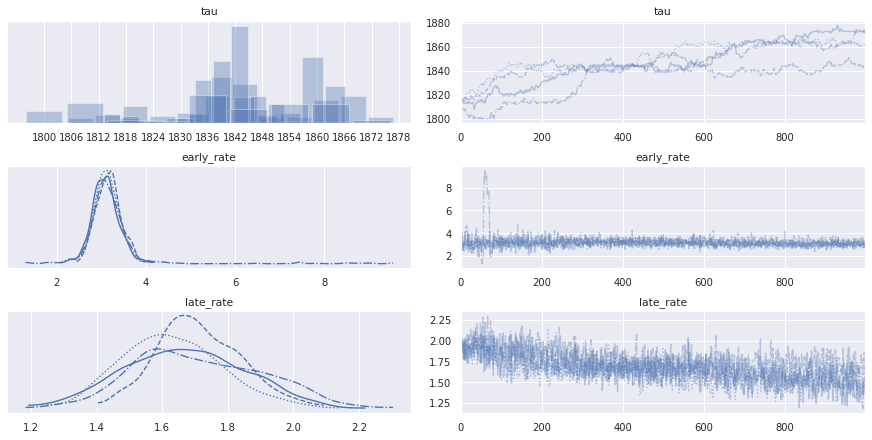

In [47]:
az.plot_trace(sample);

In [48]:
az.summary(sample)

mean      sd    hdi_3%  ...  ess_bulk  ess_tail  r_hat
tau         1844.900  16.440  1813.000  ...       6.0      15.0   1.68
early_rate     3.149   0.437     2.585  ...     259.0     257.0   1.02
late_rate      1.681   0.170     1.370  ...      11.0      39.0   1.28

[3 rows x 9 columns]

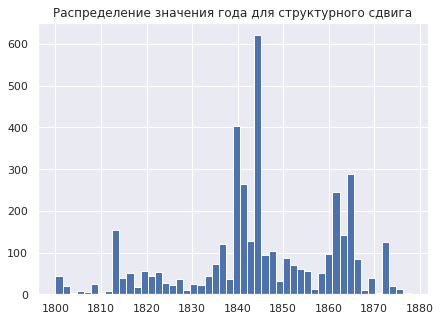

In [49]:
plt.figure(figsize=(7, 5));
plt.hist(np.array(sample.posterior.tau).ravel(), bins=50);
plt.title('Распределение значения года для структурного сдвига');


Оценим вероятность того, что $\lambda_i$ различны:

In [50]:
np.mean(np.array(sample.posterior.early_rate) - \
        np.array(sample.posterior.late_rate) > 0)

0.9975

### Задание 3. Байесовская линейная регрессия.

Набор данных - WaffleDivorce, содержащий информацию о проценте разводов в 50 штатах США.

In [29]:
DATASET_URL = 'https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/WaffleDivorce.csv'
df = pd.read_csv(DATASET_URL, sep=';')
df.head(5)

Location Loc  Population  ...  Slaves1860  Population1860  PropSlaves1860
0     Alabama  AL        4.78  ...      435080          964201            0.45
1      Alaska  AK        0.71  ...           0               0            0.00
2     Arizona  AZ        6.33  ...           0               0            0.00
3    Arkansas  AR        2.92  ...      111115          435450            0.26
4  California  CA       37.25  ...           0          379994            0.00

[5 rows x 13 columns]

Нам предлагаются следующие признаки для анализа:

* `Population`
* `MedianAgeMarriage`
* `Marriage`
* `WaffleHouses`
* `South`.

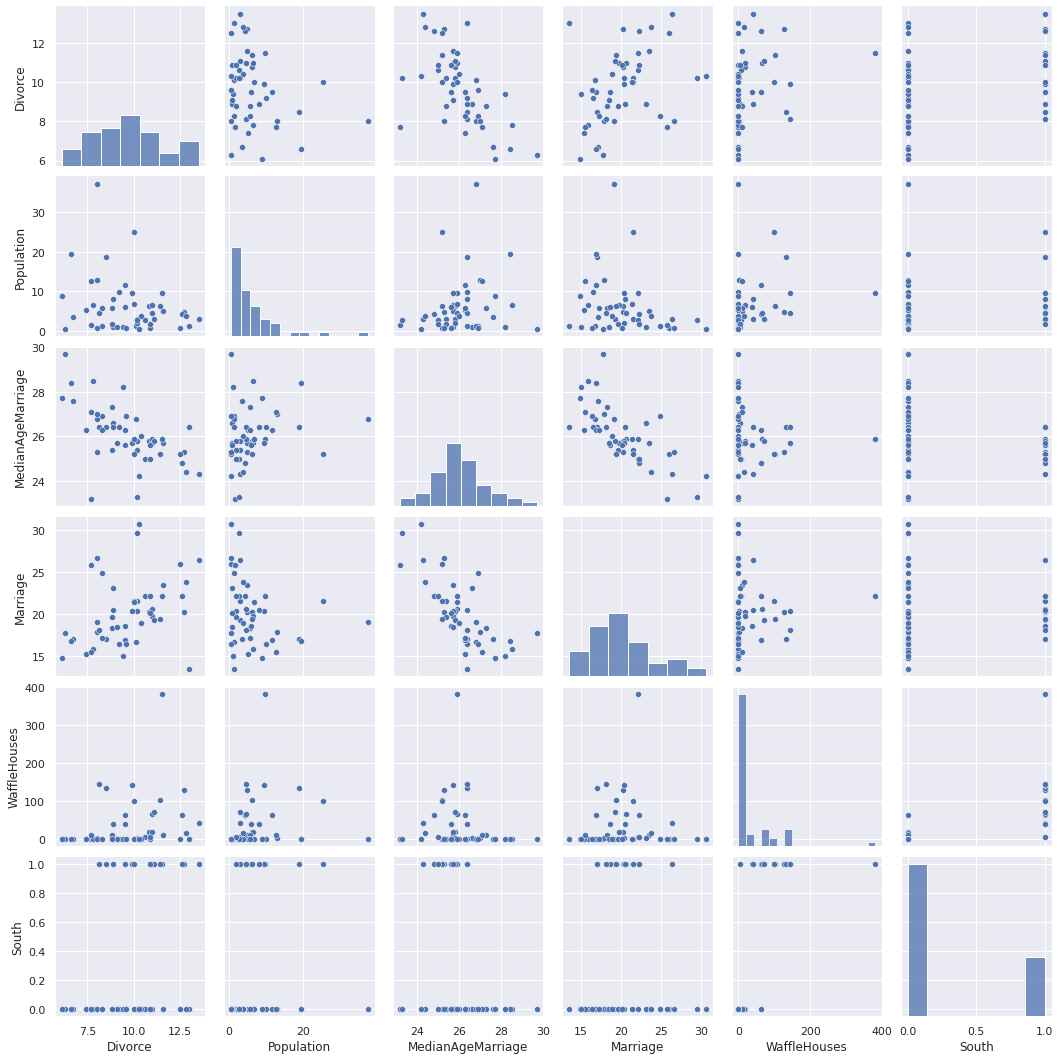

In [30]:
regr = ['Divorce', 'Population', 'MedianAgeMarriage', 'Marriage',
        'WaffleHouses', 'South']
sns.pairplot(df, x_vars=regr, y_vars=regr);

Хорошая корреляция у `Divorce` есть только с `MedianAgeMarriage` и `Marriage`, и ещё слабая с `WaffleHouses`.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


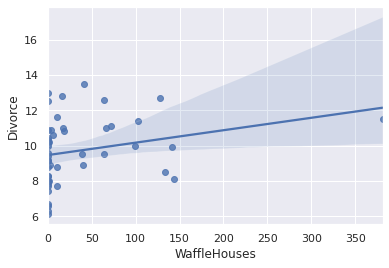

In [31]:
sns.regplot('WaffleHouses', 'Divorce', df);

Скорее всего, корреляция с числом ресторанов в штате ложная - вряд ли этот фактор как-то влияет на процент разводов.

In [32]:
X = df[['Divorce', 'Marriage', 'MedianAgeMarriage']]

In [33]:
stand = lambda x: (x-x.mean()) / x.std()
X = X.apply(stand)

Модель:

$$ \mathrm{divorce} \sim \mathcal{N}(\mu, \sigma^2). $$$$ \mu = \beta_0 + \beta_1\mathrm{marriage} + \beta_2\mathrm{age}. $$

Иначе говоря, мы подразумеваем нормальность ошибки.

In [34]:
#  случайными у нас будут коэффициенты, три переменные и сигма
def model(divorce=None, marriage=None, age=None):
  beta0 = numpyro.sample('beta0', dist.Normal(0, 0.2))
  MARRIAGE, AGE = 0, 0

  # ифы сделаны, чтобы можно было добавлять разные регрессоры в модель
  if marriage is not None:
    beta1 = numpyro.sample('beta1', dist.Normal(0, 0.5))
    MARRIAGE = beta1 * marriage

  if age is not None:
    beta2 = numpyro.sample('beta2', dist.Normal(0, 0.5))
    AGE = beta2 * age

  sigma = numpyro.sample('sigma', dist.Exponential(1))
  mu = beta0 + MARRIAGE + AGE
  numpyro.sample('obs', dist.Normal(mu, sigma), obs=divorce)

Используем в качестве регрессора только `marriage`:

In [35]:
kernel = NUTS(model)
mcmc = MCMC(sampler=kernel, num_warmup=1000, num_samples=2000, num_chains=4)
mcmc.run(random.PRNGKey(0), 
         marriage=X['Marriage'].values,
         divorce=X['Divorce'].values)
mcmc.print_summary()
samples_1 = mcmc.get_samples()

/usr/local/lib/python3.7/dist-packages/numpyro/infer/mcmc.py:275: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.num_chains, local_device_count(), self.num_chains
sample: 100%|██████████| 3000/3000 [00:00<00:00, 7530.95it/s, 3 steps of size 7.36e-01. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta0     -0.00      0.11     -0.00     -0.19      0.18   7587.82      1.00
     beta1      0.35      0.13      0.35      0.12      0.55   7265.98      1.00
     sigma      0.95      0.10      0.94      0.80      1.11   6682.60      1.00

Number of divergences: 0


In [36]:
trace_df = pd.DataFrame({'beta0': np.array(samples_1['beta0']),
                         'beta1': np.array(samples_1['beta1']),
                         'sigma': np.array(samples_1['sigma'])})

In [37]:
#plt.rc('text', usetex=True)

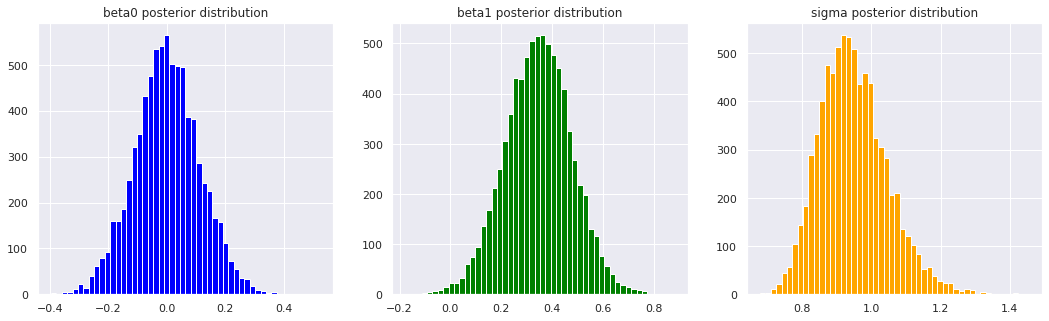

In [38]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

ax[0].hist(trace_df.beta0, bins=50, color='blue')
ax[0].set_title('beta0 posterior distribution')
ax[1].hist(trace_df.beta1, bins=50, color='green')
ax[1].set_title('beta1 posterior distribution')
ax[2].hist(trace_df.sigma, bins=50, color='orange')
ax[2].set_title('sigma posterior distribution')

fig.show();

Видно, что intercept равен нулю, в то время как коэффициеет при marriage положительный. С оценкой $\sigma$ мы удачно угадали.

[Text(0, 0.5, 'Divorce rate'),
 Text(0.5, 0, 'Marriage rate'),
 Text(0.5, 1.0, 'Regression line with 95% CI')]

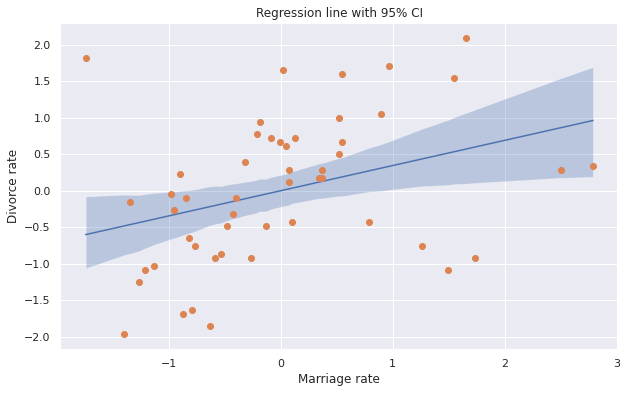

In [39]:
def plot_regression(x, y_mean, y_hpdi):
  # sort values for plotting by x axis
  idx = jnp.argsort(x)
  marriage = x[idx]
  mean = y_mean[idx]
  hpdi = y_hpdi[:, idx]
  divorce = X['Divorce'].values[idx]

  #Plot
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
  ax.plot(marriage, mean)
  ax.plot(marriage, divorce, 'o')
  ax.fill_between(marriage, hpdi[0], hpdi[1], alpha=0.3, interpolate=True)
  return ax

# compute empirical posterior over mu
posterior_mu = jnp.expand_dims(samples_1['beta0'], -1) + \
               jnp.expand_dims(samples_1['beta1'], -1) * \
               X['Marriage'].values

mean_mu = jnp.mean(posterior_mu, axis=0)
hpdi_mu = hpdi(posterior_mu, 0.95)
ax = plot_regression(X['Marriage'].values, mean_mu, hpdi_mu)
ax.set(xlabel='Marriage rate', ylabel='Divorce rate', 
         title='Regression line with 95% CI')



Собственно, здесь видно преимущество байесовского подхода: доверительный интервал гибкий, он учитывает распределение параметров (в данном случае интервал шире там, где данных для оценивания меньше) и потому нелинеен.

Теперь попробуем другие варианты:
1. Оценим модель в PyMC3 и сравним результаты.
2. Неинформативное априорное (пусть будет константа)
3. Априорное Джеффриса - оно будет инвариантным к преобразованиям, пусть и в данном случае нас интересуют сами параметры, а не функции от них.


In [58]:
# судя по всему, в PyMC3 нельзя так же сделать "гибкую" модель 
# под разное число регрессоров, как в numpyro
# придётся написать под конкретные регрессоры

with pm.Model() as lm:
  sigma = pm.Exponential('sigma', lam=1)
  alpha = pm.Normal('alpha', mu=0, sigma=0.2)
  beta_marriage  = pm.Normal('beta_marriage', mu=1, sigma=0.5)
   # beta_age  = pm.Normal('beta_age', mu=1, sigma=0.5)
   

  mu = alpha + beta_marriage * X['Marriage'].values # + beta_age * X['MedianAgeMarriage'].values
  y_lm = pm.Normal('y_lm', mu=mu, sigma=sigma, observed=X['Divorce'].values)

In [60]:
n_draws = 1500
n_burn = 500

with lm:
  lm_trace = pm.sample(draws=n_draws,
                       tune=n_burn,
                       chains=4, 
                       cores=4,
                       random_seed=np.random.seed(0))

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, beta_marriage]
INFO:pymc3:NUTS: [sigma, alpha, beta_marriage]


Sampling 4 chains for 500 tune and 1_500 draw iterations (2_000 + 6_000 draws total) took 11 seconds.
INFO:pymc3:Sampling 4 chains for 500 tune and 1_500 draw iterations (2_000 + 6_000 draws total) took 11 seconds.


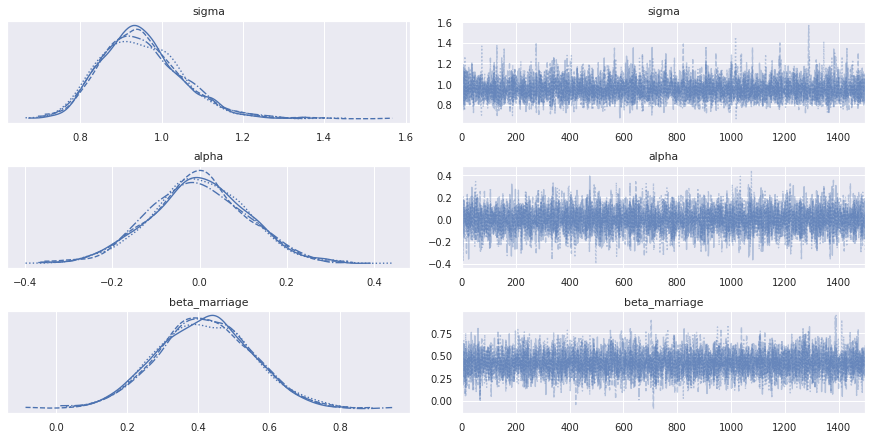

In [61]:
az.plot_trace(lm_trace);

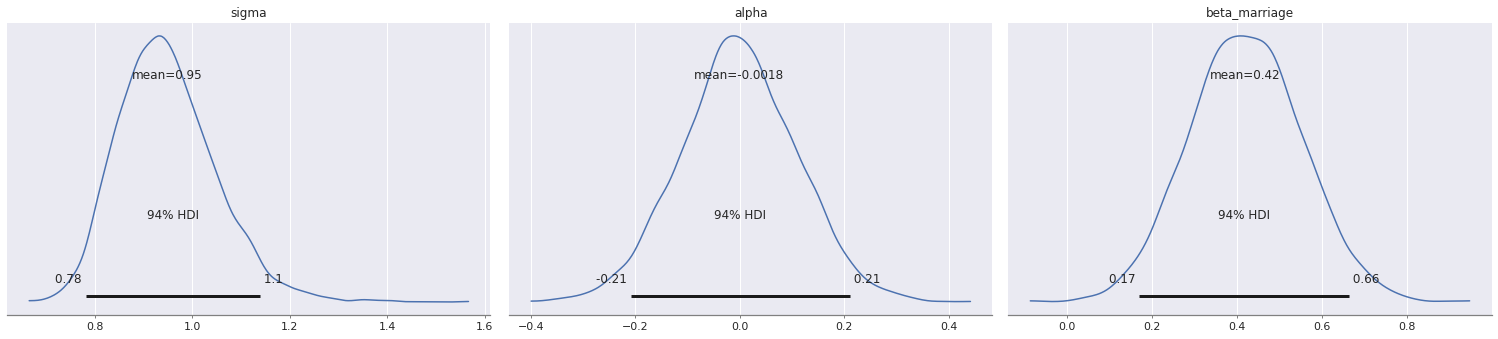

In [62]:
az.plot_posterior(lm_trace);

In [63]:
az.summary(lm_trace)

mean     sd  hdi_3%  ...  ess_bulk  ess_tail  r_hat
sigma          0.950  0.100   0.781  ...    6996.0    4422.0    1.0
alpha         -0.002  0.111  -0.208  ...    7424.0    4450.0    1.0
beta_marriage  0.420  0.132   0.169  ...    7013.0    4201.0    1.0

[3 rows x 9 columns]

Единственное, что не очень хоршо - коэффициент при marriage отличается. Теперь сделаем модель с двумя регрессорами:

In [64]:
n_draws = 1500
n_burn = 500

with pm.Model() as lm:
  sigma = pm.Exponential('sigma', lam=1)
  alpha = pm.Normal('alpha', mu=0, sigma=0.2)
  beta_marriage  = pm.Normal('beta_marriage', mu=1, sigma=0.5)
  beta_age  = pm.Normal('beta_age', mu=1, sigma=0.5)
   

  mu = alpha + beta_marriage * X['Marriage'].values + beta_age * X['MedianAgeMarriage'].values
  y_lm = pm.Normal('y_lm', mu=mu, sigma=sigma, observed=X['Divorce'].values)

with lm:
  lm_trace_multi = pm.sample(draws=n_draws,
                       tune=n_burn,
                       chains=4, 
                       cores=4,
                       random_seed=np.random.seed(0))

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, beta_marriage, beta_age]
INFO:pymc3:NUTS: [sigma, alpha, beta_marriage, beta_age]


Sampling 4 chains for 500 tune and 1_500 draw iterations (2_000 + 6_000 draws total) took 15 seconds.
INFO:pymc3:Sampling 4 chains for 500 tune and 1_500 draw iterations (2_000 + 6_000 draws total) took 15 seconds.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1b8753b850>,
      dtype=object)

mean     sd  hdi_3%  ...  ess_bulk  ess_tail  r_hat
sigma          0.846  0.094   0.687  ...    4396.0    4288.0    1.0
alpha          0.002  0.101  -0.183  ...    4489.0    3833.0    1.0
beta_marriage  0.116  0.167  -0.203  ...    3966.0    3963.0    1.0
beta_age      -0.433  0.167  -0.754  ...    3788.0    4218.0    1.0

[4 rows x 9 columns]

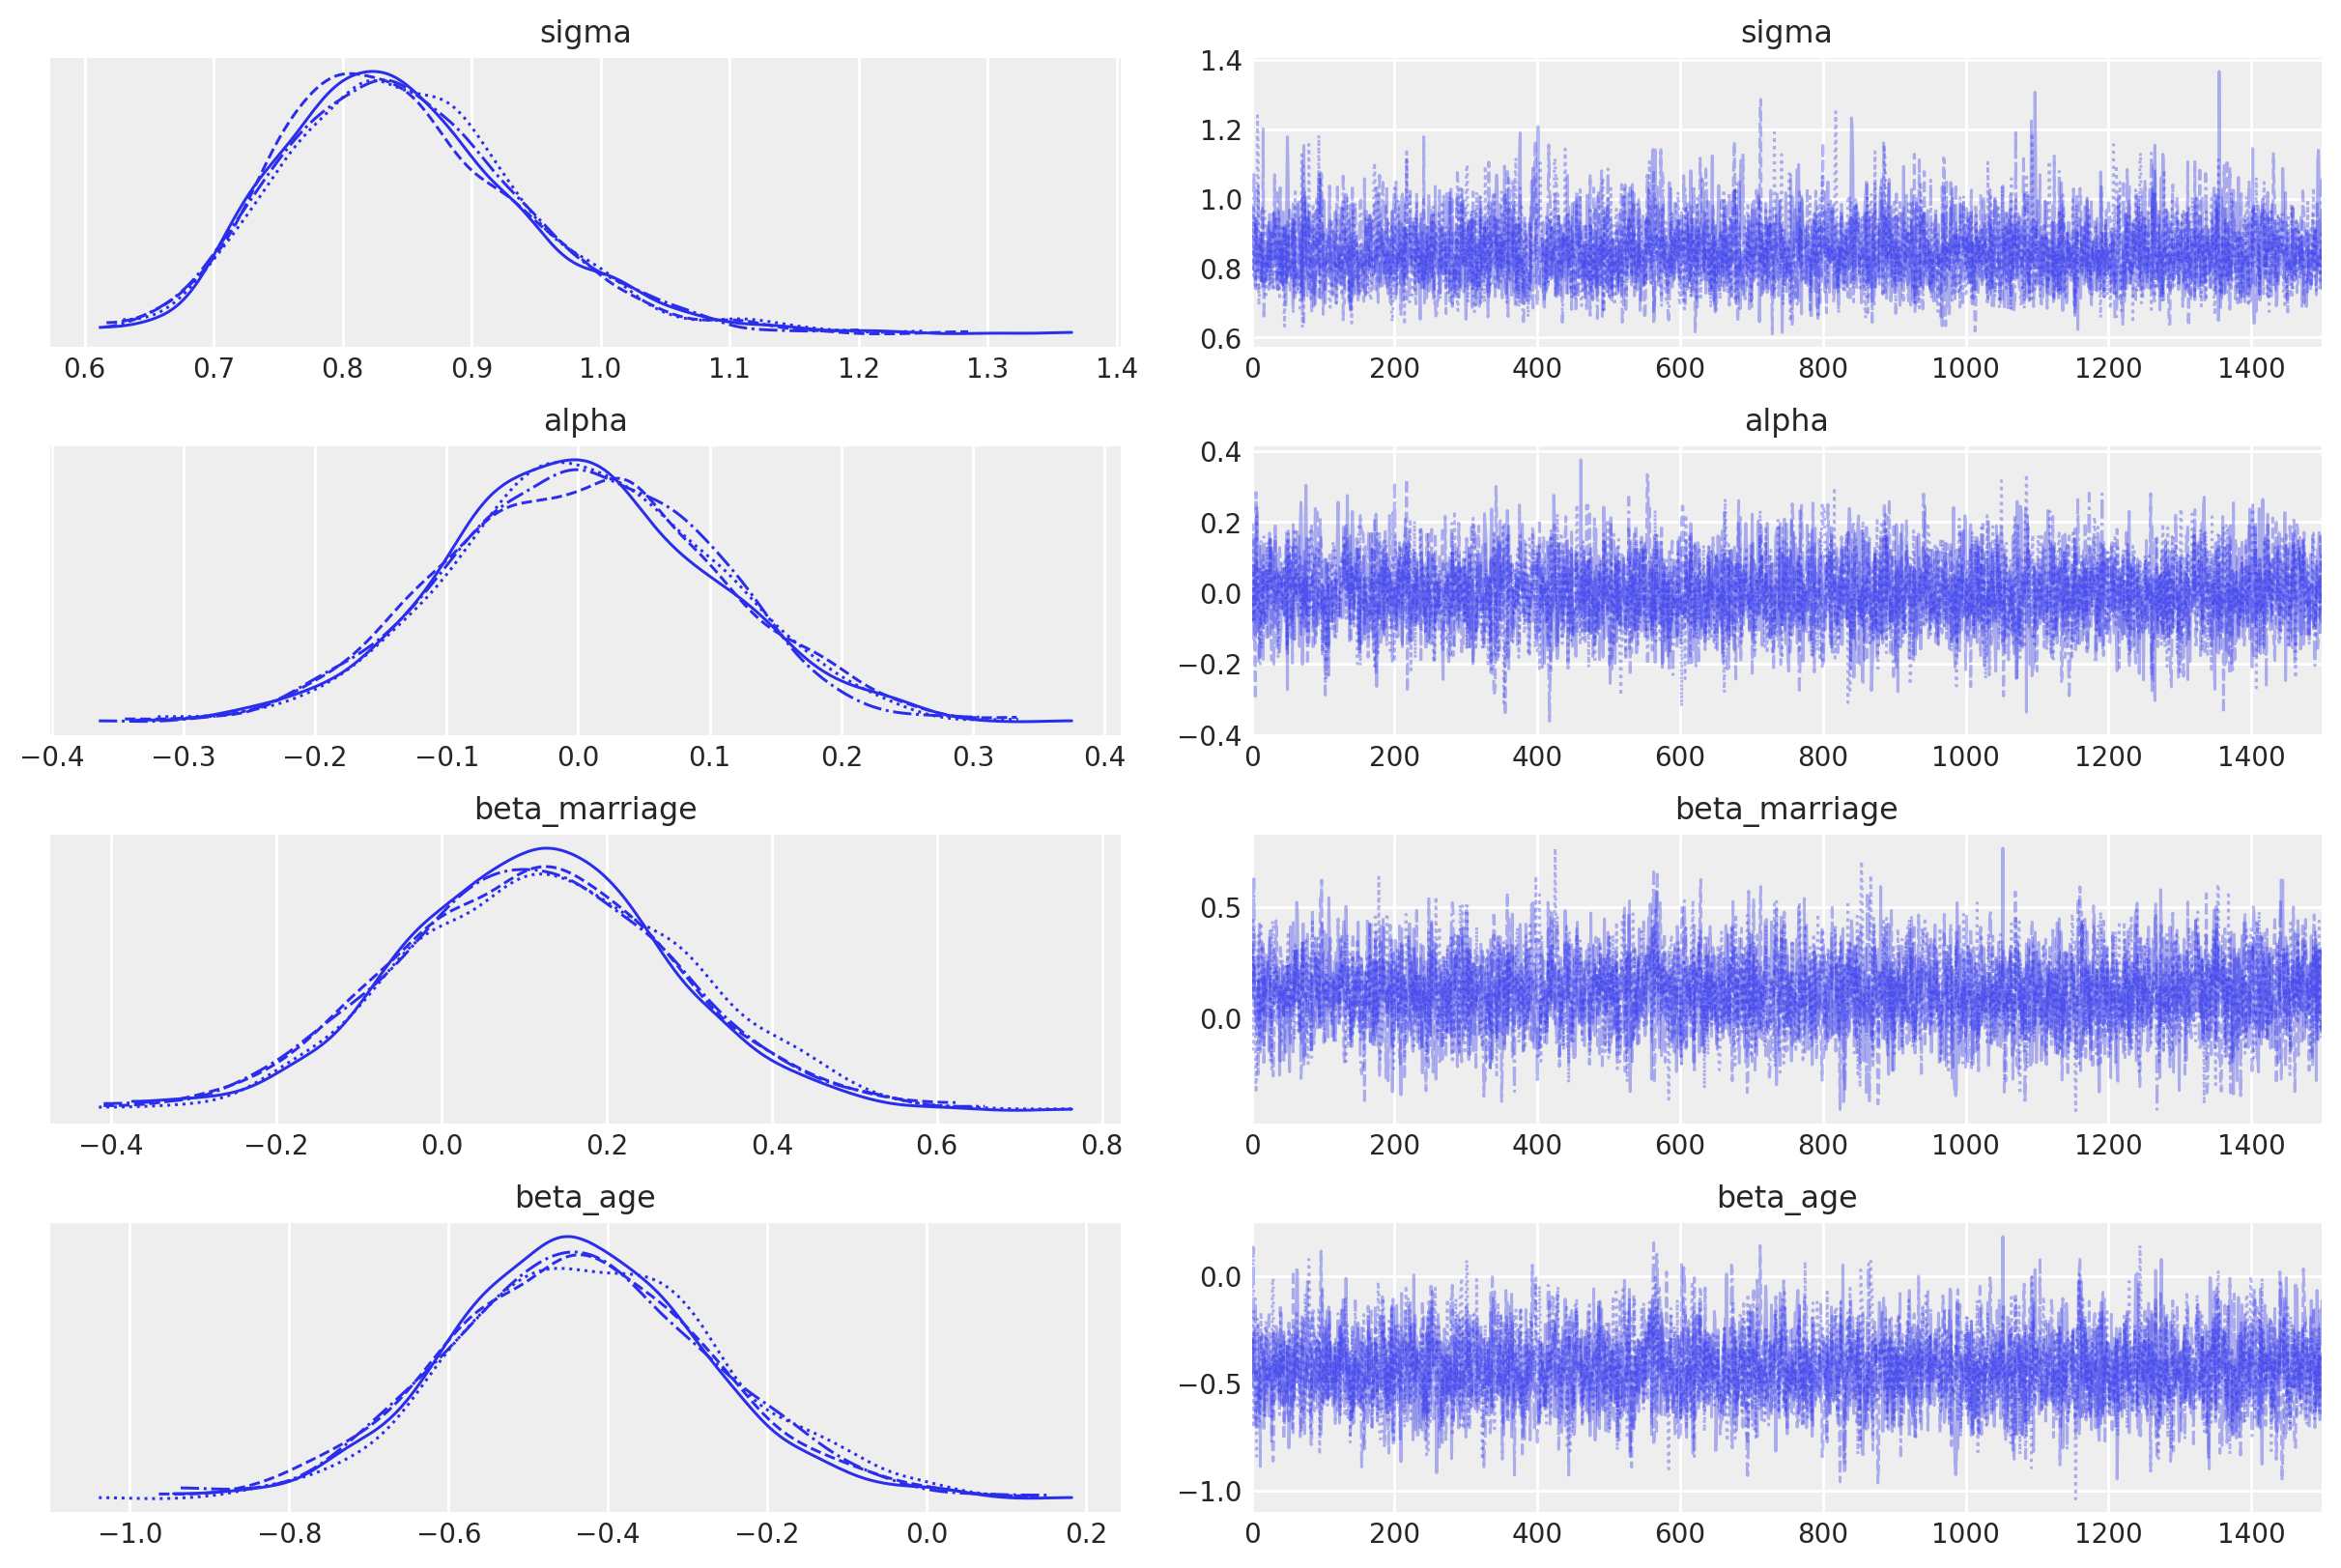

In [73]:
pm.plot_trace(lm_trace_multi);
az.summary(lm_trace_multi)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  


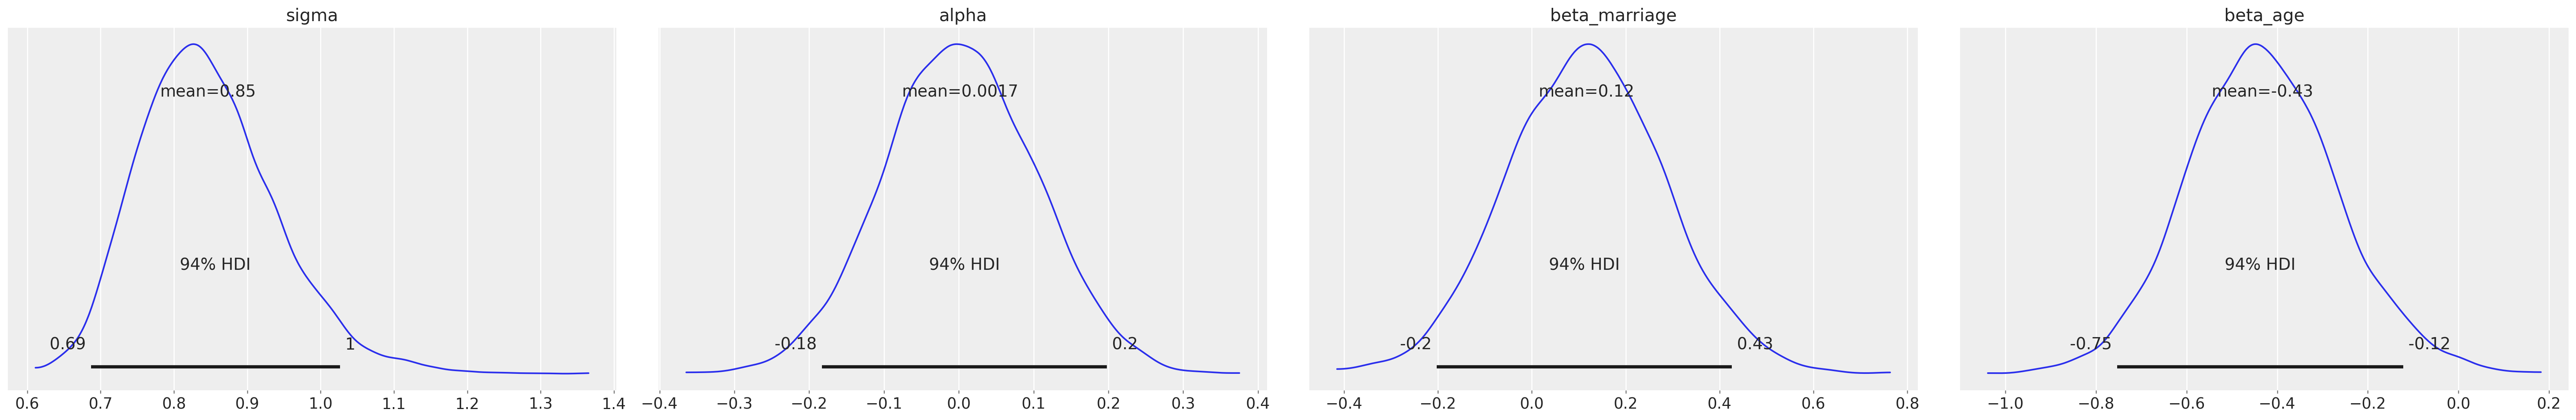

In [71]:
az.plot_posterior(lm_trace_multi);
plt.tight_layout();

Теперь ситуация изменилась: коэффициент при `Marriage` оказался незначимым, в отличие от `MedianAgeMarriage`.

Попробуем uninformative prior (допустим, зададим его как непрерывное равномерное на отрезке $[0, 1]$. Сделаем побольше шагов и уничтожим побольше исходных сэмплов, поскольку теперь мы задали более общее априорное.

In [93]:
n_draws = 3000
n_burn = 1000

with pm.Model() as lm_uninf:
  sigma = pm.Exponential('sigma', lam=1)
  alpha = pm.Uniform('alpha', lower=0, upper=1)
  beta_marriage  = pm.Uniform('beta_marriage', lower=0, upper=1)
  beta_age  = pm.Uniform('beta_age', lower=0, upper=1)
   

  mu = alpha + beta_marriage * X['Marriage'].values + beta_age * X['MedianAgeMarriage'].values
  y_lm = pm.Normal('y_lm', mu=mu, sigma=sigma, observed=X['Divorce'].values)

with lm_uninf:
  trace_uninf = pm.sample(draws=n_draws,
                       tune=n_burn,
                       chains=4, 
                       cores=4,
                       random_seed=np.random.seed(0))

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, beta_marriage, beta_age]
INFO:pymc3:NUTS: [sigma, alpha, beta_marriage, beta_age]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 31 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 31 seconds.


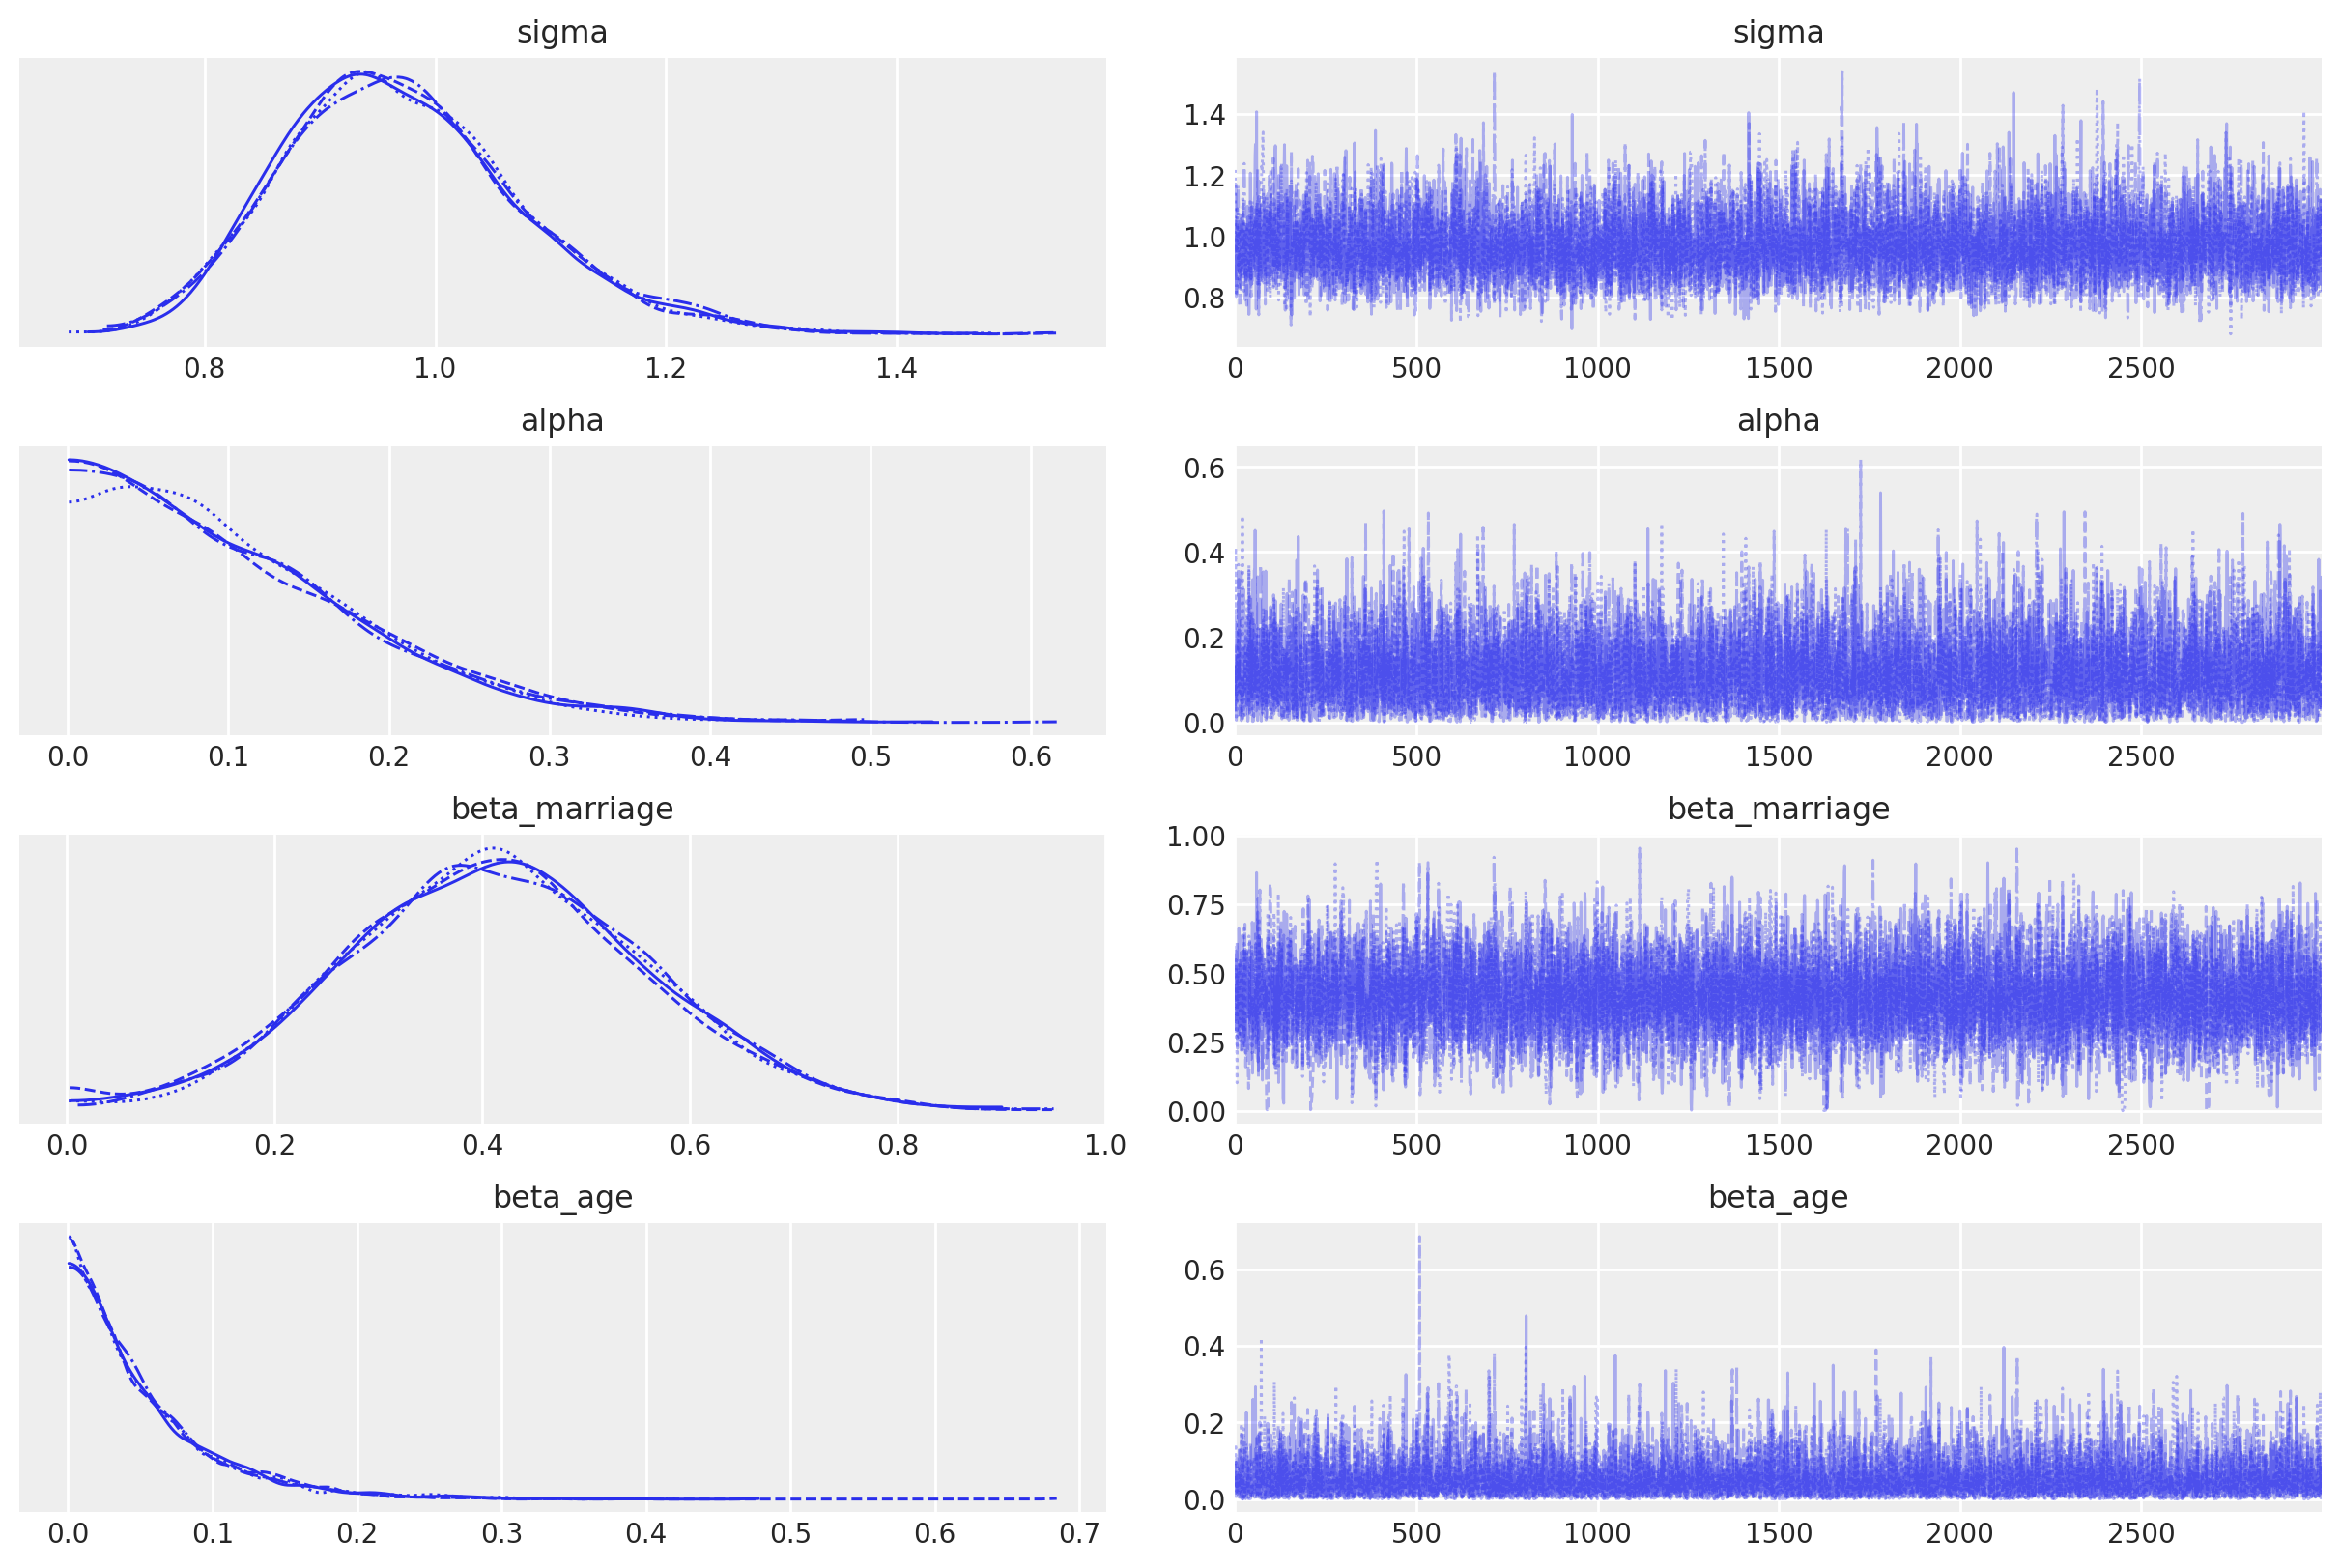

In [94]:
az.plot_trace(trace_uninf);

In [95]:
az.summary(trace_uninf)

mean     sd  hdi_3%  ...  ess_bulk  ess_tail  r_hat
sigma          0.972  0.105   0.783  ...    7883.0    7562.0    1.0
alpha          0.109  0.084   0.000  ...    6295.0    4393.0    1.0
beta_marriage  0.414  0.146   0.152  ...    6909.0    5228.0    1.0
beta_age       0.053  0.053   0.000  ...    7423.0    5188.0    1.0

[4 rows x 9 columns]

Интересно, что коэффициенты изменились достаточно сильно, теперь, например, `beta_marriage` значима. Почему всё плохо?
* Заметим, что равномерное распределение - наверно, не самая удачная вероятностная модель для коэффициентов, судя по их апостериорному распределению. 
* Oчевидно, что между `MedianAgeMarriage` и `Divorce` отрицательная корреляция (это заметно на графике и разумно теоретически). Поэтому для отрицательного коэффициента априорное распределение $[0, 1]$, конечно, не лучший выбор. 
* У нас маленькая выборка, поэтому вес ML-оценки не такой большой, и априорное распределение достаточно сильно влияет на итоговый результат.

Сравним это с тем, что нам выдаст обычная частотная линейная регрессия:

In [81]:
import statsmodels.api as sm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [86]:
exog = sm.add_constant(X[['Marriage', 'MedianAgeMarriage']])
freq_lm = sm.OLS(endog=X.Divorce.values, exog=exog)
fitted = freq_lm.fit()
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.363
Model:                            OLS   Adj. R-squared:                  0.336
Method:                 Least Squares   F-statistic:                     13.42
Date:                Wed, 21 Jul 2021   Prob (F-statistic):           2.46e-05
Time:                        18:32:20   Log-Likelihood:                -59.150
No. Observations:                  50   AIC:                             124.3
Df Residuals:                      47   BIC:                             130.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               6.21e-16      0.115   5.39e-15      1.000      -0.232       0.232
Marriage             -0.1186      0.168     -0.706      0.484      -0.457       0.219
MedianAgeMarriage    -0.6828      0.168     -4.065      0.000      -1.021      -0.345
==============================================================================
Omnibus:                        2.545   Durbin-Watson:                   1.903
Prob(Omnibus):                  0.280   Jarque-Bera (JB):                1.595
Skew:                          -0.301   Prob(JB):                        0.450
Kurtosis:                       3.635   Cond. No.                         2.48
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Нарисуем оценки, полученные байесовским методом, и частотные оценки:

In [106]:
posteriors = pd.DataFrame({x: np.ravel(np.array(lm_trace_multi.posterior[x])) \
                           for x in ['sigma', 'alpha', 'beta_marriage', 'beta_age']})
posteriors.head()

sigma     alpha  beta_marriage  beta_age
0  0.862725  0.003004       0.312431 -0.500762
1  0.891655 -0.097075       0.329872 -0.294327
2  0.858458 -0.108375       0.180115 -0.333093
3  0.861877 -0.130803       0.080946 -0.520420
4  0.824593  0.063446       0.234086 -0.254141

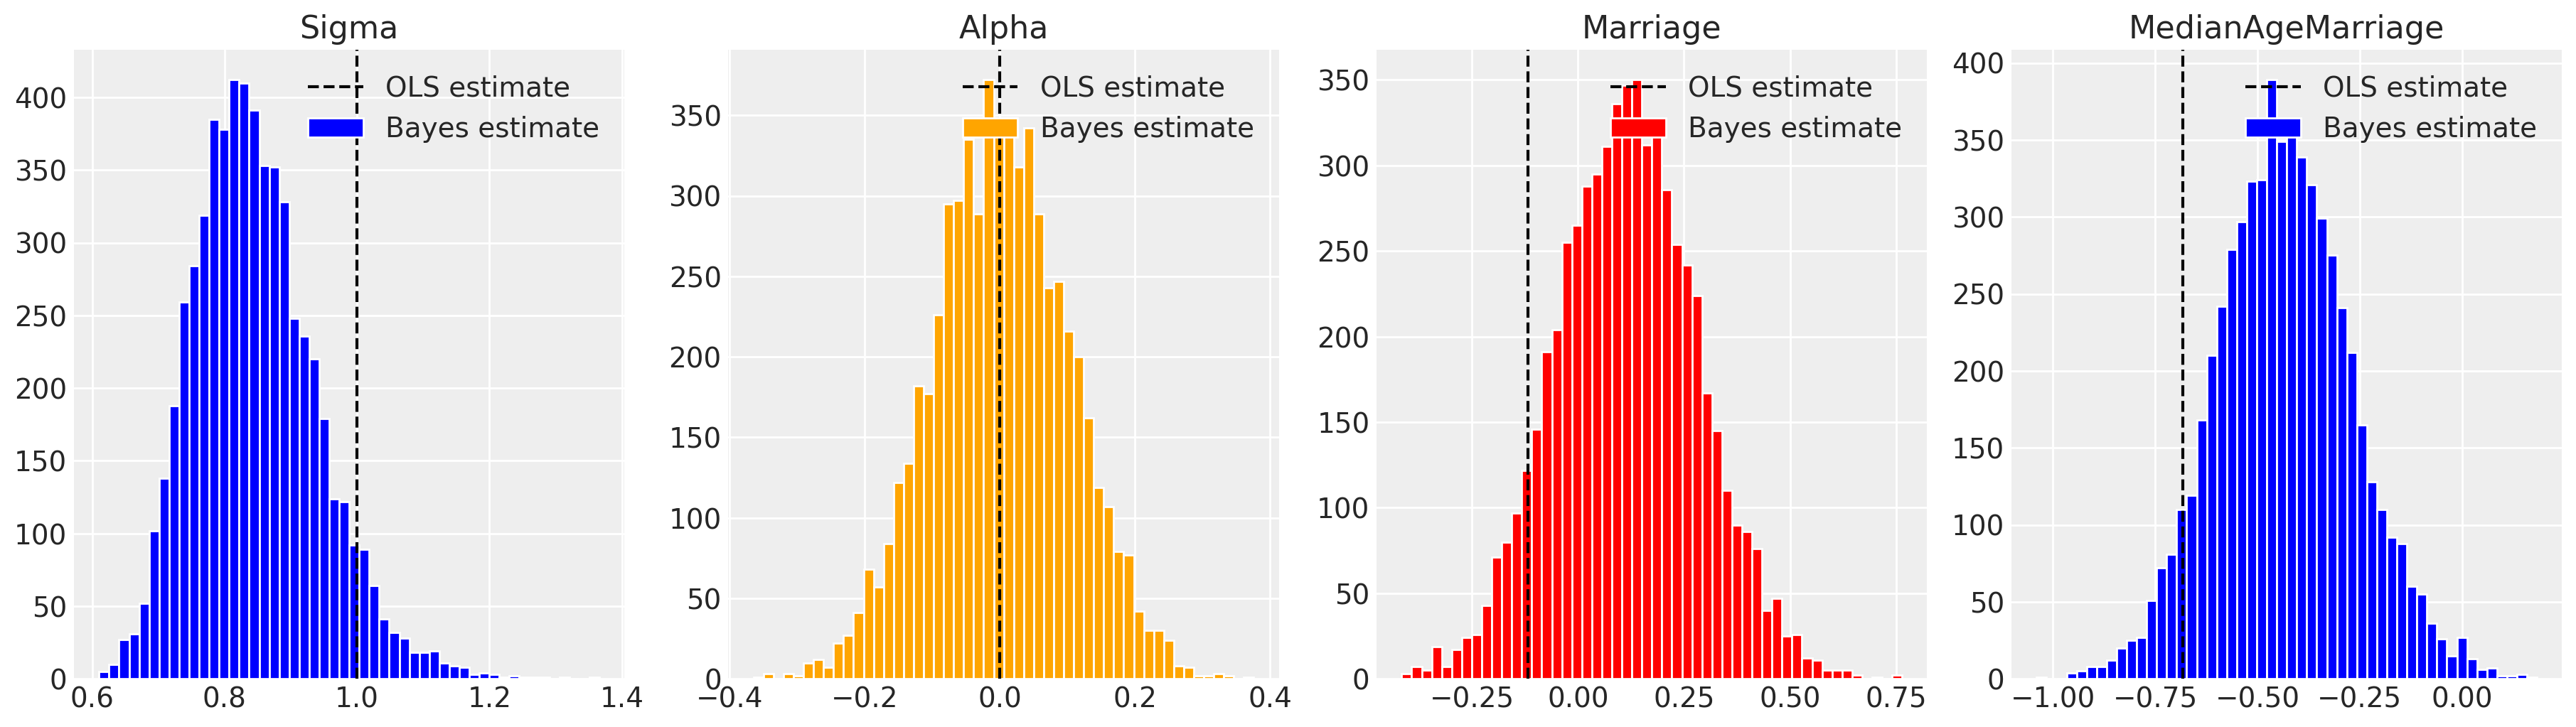

In [117]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(18, 5))

ax[0].hist(posteriors.sigma.values, bins=50, color='blue', label='Bayes estimate')
ax[0].axvline(1.0, color='black', linestyle='--', label='OLS estimate')
ax[0].set_title('Sigma')
ax[0].legend()

ax[1].hist(posteriors.alpha.values, bins=50, color='orange', label='Bayes estimate')
ax[1].axvline(fitted.params['const'], color='black', linestyle='--', label='OLS estimate')
ax[1].set_title('Alpha')
ax[1].legend()

ax[2].hist(posteriors.beta_marriage, bins=50, color='red', label='Bayes estimate')
ax[2].axvline(fitted.params.Marriage, color='black', linestyle='--', label='OLS estimate')
ax[2].set_title('Marriage')
ax[2].legend()

ax[3].hist(posteriors.beta_age, bins=50, color='blue', label='Bayes estimate')
ax[3].axvline(fitted.params.MedianAgeMarriage, color='black', linestyle='--', label='OLS estimate')
ax[3].set_title('MedianAgeMarriage')
ax[3].legend()

fig.show();

Заметно, что оценки не сликшом расходятся, но всё же разница приличная - выборка мала.